In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import chi2, SelectPercentile, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn import *
from scipy import stats
import json
import csv
import re
import itertools
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
train = pd.read_json('recipe_train.json')
test = pd.read_json('recipe_test.json')

In [4]:
#lemmatizing?
f = open('recipe_train.json', 'r') 
w = open('clean_train.json','w') 
flag= True                      
while True:
    ch=f.read(1)
    if ch=='"':
        flag= not flag
    if ch==' ' and flag==False:
        ch1='_'                  
    else:
        ch1=ch
    w.write(ch1)                  
    if not ch: break
f.close()
w.close()

f = open('recipe_test.json', 'r') 
w = open('clean_test.json','w') 
flag= True                      
while True:
    ch=f.read(1)
    if ch=='"':
        flag= not flag
    if ch==' ' and flag==False:
        ch1='_'                 
    else:
        ch1=ch
    w.write(ch1)                   
    if not ch: break
f.close()
w.close()

In [5]:
def read(filename):
    with open(filename) as data_file:    
        data = json.load(data_file)
        
    ids, cuisines, ingredients = [], [], []
    if 'cuisine' in data[0].keys(): 
        for i in range(len(data)):
            ids.append(data[i]['id'])
            cuisines.append(data[i]['cuisine'])
            ingredients.append(data[i]['ingredients'])
    else:
        for i in range(len(data)):
            ids.append(data[i]['id'])
            ingredients.append(data[i]['ingredients'])
                
    return ids, cuisines, ingredients

##tainid, trainc, traini = read('recipe_train.json')
##testid, testc, testi = read('recipe_train.json')

In [6]:
def deletenoise(ingredients):
    ingredients = [[re.sub("\d+", "", x) for x in y] for y in ingredients] ##delete numbers
    ingredients = [[x.replace("-", " ") for x in y] for y in ingredients] ##delete other special characters
    ingredients = [[x.replace("&", " ") for x in y] for y in ingredients] 
    ingredients = [[x.replace("'", " ") for x in y] for y in ingredients] 
    ingredients = [[x.replace("''", " ") for x in y] for y in ingredients] 
    ingredients = [[x.replace("%", " ") for x in y] for y in ingredients] 
    ingredients = [[x.replace("!", " ") for x in y] for y in ingredients] 
    ingredients = [[x.replace("(", " ") for x in y] for y in ingredients] 
    ingredients = [[x.replace(")", " ") for x in y] for y in ingredients] 
    ingredients = [[x.replace("/", " ") for x in y] for y in ingredients] 
    ingredients = [[x.replace("/", " ") for x in y] for y in ingredients] 
    ingredients = [[x.replace(",", " ") for x in y] for y in ingredients] 
    ingredients = [[x.replace(".", " ") for x in y] for y in ingredients] 
    ingredients = [[re.sub( '\s+', ' ', x).strip() for x in y] for y in ingredients] ##delete extra space
    ingredients = [[x.lower() for x in y] for y in ingredients] ##make lowercase

    return ingredients
##deletenoise(trainIngr)

In [7]:
def deleteunits(ingredients):
    unitlist = ['g', 'lb', 's', 'n']   
    def check(string):
        s = string.split()
        isthere  = [word for word in s if word.lower() not in unitlist]
        return ' '.join(isthere)
    return [[check(x) for x in y] for y in ingredients] 

##deleteunits(trainIngr)

In [8]:
train['all'] = train['ingredients'].map(";".join)
train.head()

,cuisine,id,ingredients,all
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce;black olives;grape tomatoes;ga...
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour;ground pepper;salt;tomatoes;ground...
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",eggs;pepper;salt;mayonaise;cooking oil;green c...
3,indian,22213,"[water, vegetable oil, wheat, salt]",water;vegetable oil;wheat;salt
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",black pepper;shallots;cornflour;cayenne pepper...


In [9]:
cv = CountVectorizer()

In [10]:
X = cv.fit_transform(train['all'].values)

In [11]:
X.shape

(39774, 3051)

In [12]:
print(list(cv.vocabulary_.keys())[:100])

[u'unflavored', u'mackerel', u'yellow', u'sichuan', u'negi', u'clotted', u'asian', u'bucatini', u'canes', u'hyssop', u'segments', u'pancetta', u'manis', u'peanuts', u'deli', u'rise', u'gremolata', u'jack', u'softened', u'icing', u'gold\xe2', u'caramels', u'baking', u'broiler', u'wholemeal', u'fruitcake', u'chambord', u'frozen', u'woods', u'moulard', u'cholesterol', u'poppy', u'uncooked', u'muscovy', u'orzo', u'jamaica', u'speck', u'clover', u'ravva', u'almond', u'bacon', u'japanese', u'millet', u'brill', u'soppressata', u'chee', u'cactus', u'blue', u'fontina', u'mascarpone', u'tipo', u'cooking', u'fingers', u'togarashi', u'salsify', u'galangal', u'new', u'zesty', u'croutons', u'crunch', u'hero', u'devein', u'kefalotyri', u'herb', u'mazola\xe2', u'jasmine', u'ramps', u'broccolini', u'marnier', u'pate', u'jamon', u'textured', u'active', u'100', u'johnsonville', u'mozzarella', u'dry', u'tumeric', u'leaves', u'stevia', u'dri', u'mezzetta', u'chopmeat', u'smoke', u'bertolli', u'aka', u'pack

In [13]:
enc = LabelEncoder()
y = enc.fit_transform(train.cuisine)

In [14]:
y[:100]

array([ 6, 16,  4,  7,  7, 10, 17,  9, 13,  9,  9,  3,  9, 13,  9,  7,  1,
        9, 18, 19, 18, 13, 16,  3,  9,  3,  2,  9,  3, 13,  9,  2, 13, 18,
        9,  2,  9,  4, 16, 16,  9,  0, 13,  7, 13,  3,  5, 16, 16, 16, 11,
       16,  9, 16,  9, 10, 11,  7,  9,  8, 18, 18,  7, 10,  9, 18, 12,  5,
        5, 16, 17,  7, 14,  9,  9, 14, 14, 19, 11, 13,  2, 16,  5,  7,  7,
        9,  9,  7, 12, 17,  9, 16, 16,  6, 13, 13, 16,  7,  9,  9])

In [15]:
enc.classes_

array([u'brazilian', u'british', u'cajun_creole', u'chinese', u'filipino',
       u'french', u'greek', u'indian', u'irish', u'italian', u'jamaican',
       u'japanese', u'korean', u'mexican', u'moroccan', u'russian',
       u'southern_us', u'spanish', u'thai', u'vietnamese'], dtype=object)

In [16]:
#try with logistic regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [17]:
logistic = LogisticRegression(class_weight='balanced')
logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [18]:
logistic.score(X_test, y_test)

0.7684475172847266

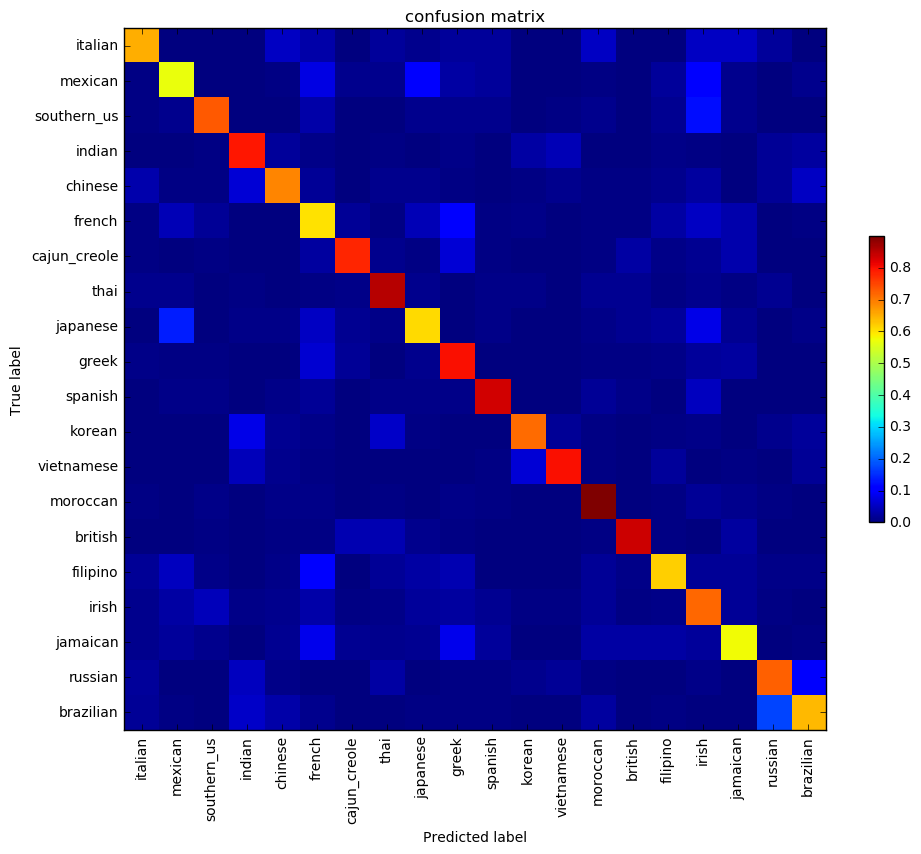

In [19]:
plt.figure(figsize=(10, 10))

cm = confusion_matrix(y_test, logistic.predict(X_test))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, interpolation='nearest')
plt.title("confusion matrix")
plt.colorbar(shrink=0.3)
cuisines = train['cuisine'].value_counts().index
tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [20]:
y_pred = logistic.predict(X_test)
print(classification_report(y_test, y_pred, target_names=cuisines))

              precision    recall  f1-score   support

     italian       0.47      0.65      0.55        92
     mexican       0.49      0.57      0.52       175
 southern_us       0.74      0.73      0.74       316
      indian       0.84      0.80      0.82       571
     chinese       0.63      0.69      0.66       161
      french       0.59      0.60      0.60       550
cajun_creole       0.73      0.78      0.76       237
        thai       0.88      0.85      0.87       558
    japanese       0.42      0.61      0.50       131
       greek       0.89      0.80      0.85      1577
     spanish       0.60      0.83      0.70        96
      korean       0.80      0.72      0.76       289
  vietnamese       0.73      0.80      0.77       163
    moroccan       0.94      0.90      0.92      1315
     british       0.73      0.84      0.78       149
    filipino       0.43      0.62      0.51        97
       irish       0.76      0.72      0.74       850
    jamaican       0.44    

In [21]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [22]:
rf.score(X_test, y_test)

0.707605279698303

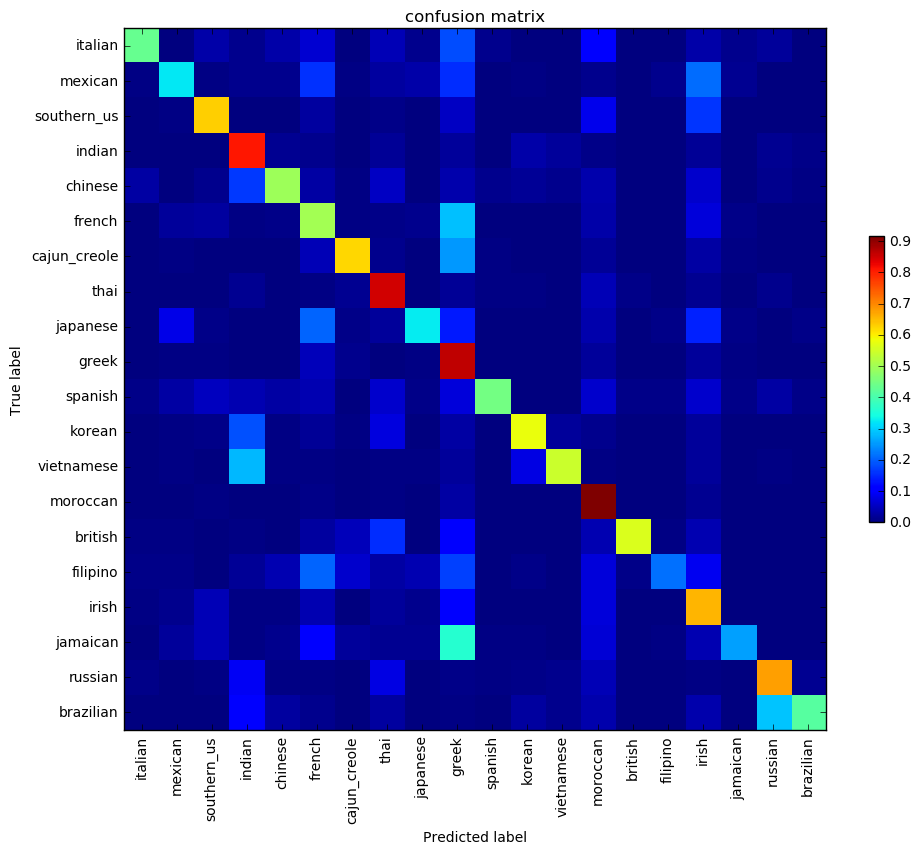

In [23]:
plt.figure(figsize=(10, 10))

cm = confusion_matrix(y_test, rf.predict(X_test))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, interpolation='nearest')
plt.title("confusion matrix")
plt.colorbar(shrink=0.3)
cuisines = train['cuisine'].value_counts().index
tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Feature Engineering

In [24]:
cleantrain = pd.read_json('clean_train.json')
cleantest = pd.read_json('clean_test.json')

In [25]:
cleantrainId, cleantrainC, cleantrainIn = read('clean_train.json')
cleantestId, cleantestC, cleantestIn = read('clean_test.json')

In [26]:
cleantrain.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine_lettuce, black_olives, grape_tomatoes..."
1,southern_us,25693,"[plain_flour, ground_pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking_oil, g..."
3,indian,22213,"[water, vegetable_oil, wheat, salt]"
4,indian,13162,"[black_pepper, shallots, cornflour, cayenne_pe..."


In [27]:
cleantrainIn = deletenoise(cleantrainIn)
cleantrainIn = deleteunits(cleantrainIn)
cleantestIn = deletenoise(cleantestIn)
cleantestIn = deleteunits(cleantestIn)

In [28]:
def features(ingredients, uniques):
    fwhole = np.zeros((len(ingredients), len(uniques)))
    for i in range(len(ingredients)):
        for j in ingredients[i]:
            fwhole[i, uniques.index(j)] = 1
            
    new_uniques = []
    for m in uniques:
        new_uniques.append(m.split())
    new_uniques = list(set(list(itertools.chain.from_iterable(new_uniques))))
    
    feach = np.zeros((len(ingredients), len(new_uniques))).astype(np.uint8)
    for i in range(len(ingredients)):
        for j in ingredients[i]:
            for k in j.split():
                feach[i, new_uniques.index(k)] = 1
            
    return np.hstack((fwhole, feach)).astype(bool)

In [29]:
from time import time
from time import sleep

In [30]:
le = LabelEncoder()
labels = le.fit_transform(train.cuisine)

In [31]:
le.classes_

array([u'brazilian', u'british', u'cajun_creole', u'chinese', u'filipino',
       u'french', u'greek', u'indian', u'irish', u'italian', u'jamaican',
       u'japanese', u'korean', u'mexican', u'moroccan', u'russian',
       u'southern_us', u'spanish', u'thai', u'vietnamese'], dtype=object)

In [32]:
ctrain, ctest, ltrain, ltest = train_test_split(cleantrainIn, labels, test_size=0.2)

In [33]:
uniques = list(set([item for sublist in cleantrainIn + cleantestIn for item in sublist]))

In [34]:
trainf = features(cleantrainIn, uniques)

In [35]:
ctrain, ctest, ltrain, ltest = train_test_split(trainf, labels, test_size=0.2)

# Logistic Regression

In [36]:
t0 = time()
lr = LogisticRegression()
lr.fit(ctrain, ltrain)
print lr.score(ctest, ltest)
print("%0.2f seconds" % (time() - t0))

0.781898177247
89.34 seconds


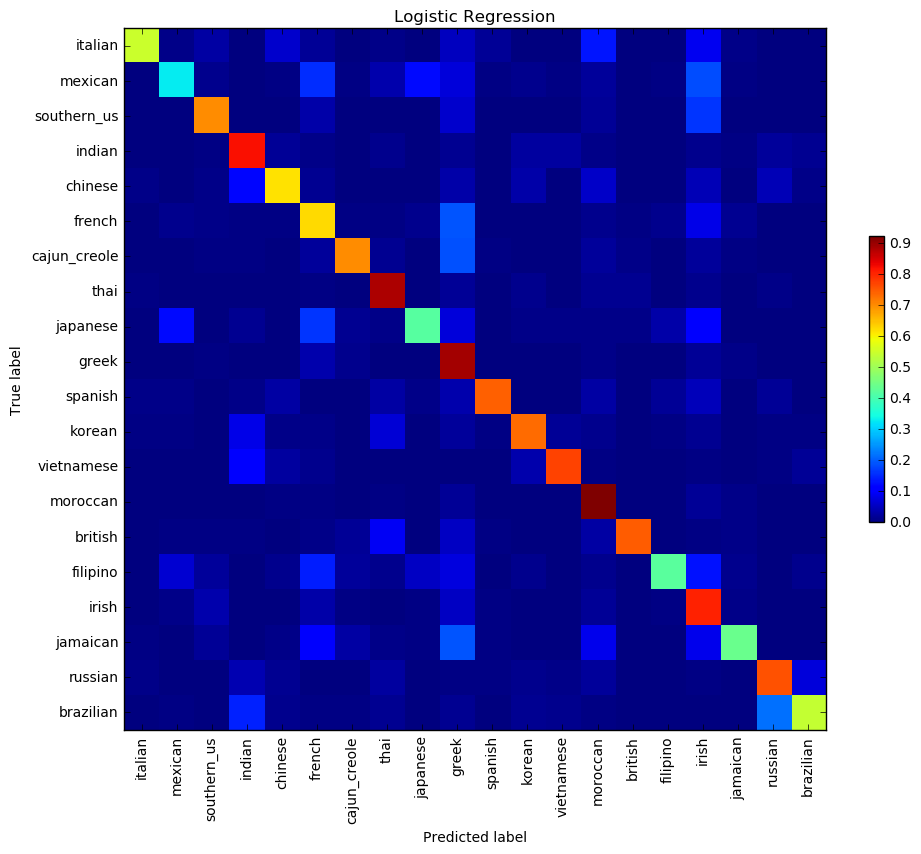

In [37]:
plt.figure(figsize=(10, 10))

cm = confusion_matrix(ltest, lr.predict(ctest))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, interpolation='nearest')
plt.title('Logistic Regression')
plt.colorbar(shrink=0.3)
cuisines = train['cuisine'].value_counts().index
tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Random Forest

In [38]:
t0 = time()
rf = RandomForestClassifier()
rf.fit(ctrain, ltrain)
print rf.score(ctest, ltest)
print("%0.2f seconds" % (time() - t0))

0.668510370836
22.95 seconds


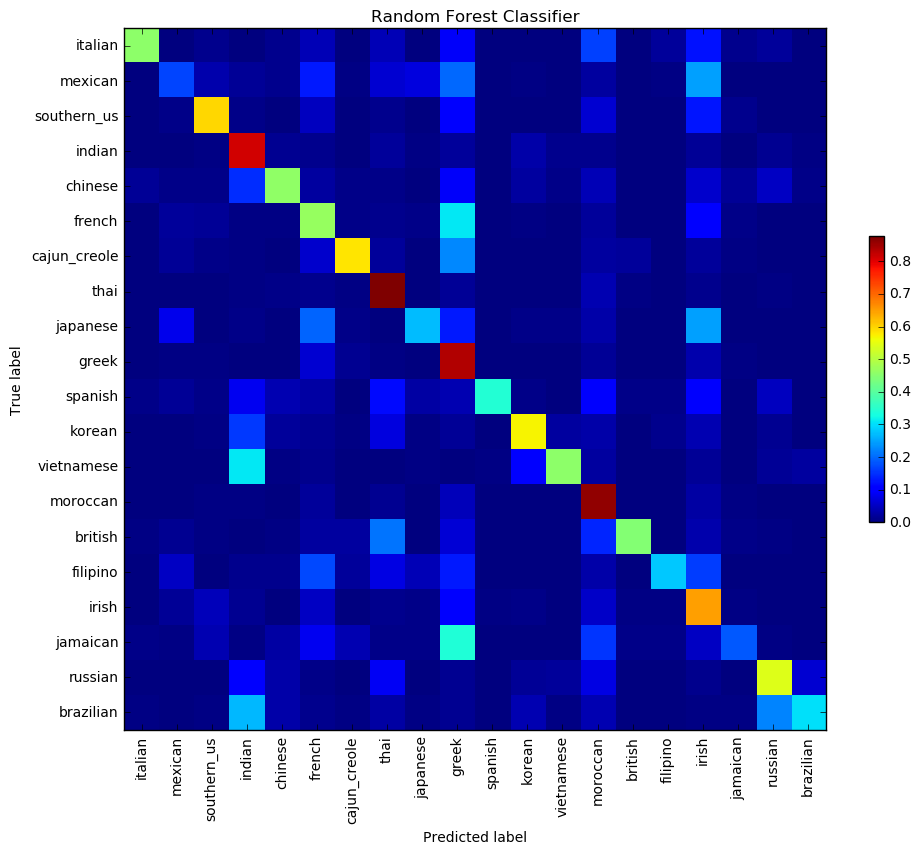

In [39]:
plt.figure(figsize=(10, 10))

cm = confusion_matrix(ltest, rf.predict(ctest))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, interpolation='nearest')
plt.title('Random Forest Classifier')
plt.colorbar(shrink=0.3)
cuisines = train['cuisine'].value_counts().index
tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Linear SVC

In [40]:
lsvc = svm.LinearSVC(C=0.5, dual=True)
lsvc.fit(ctrain, ltrain)
print lsvc.score(ctest, ltest)
print("%0.2f seconds" % (time() - t0))

0.767316153363
38.67 seconds


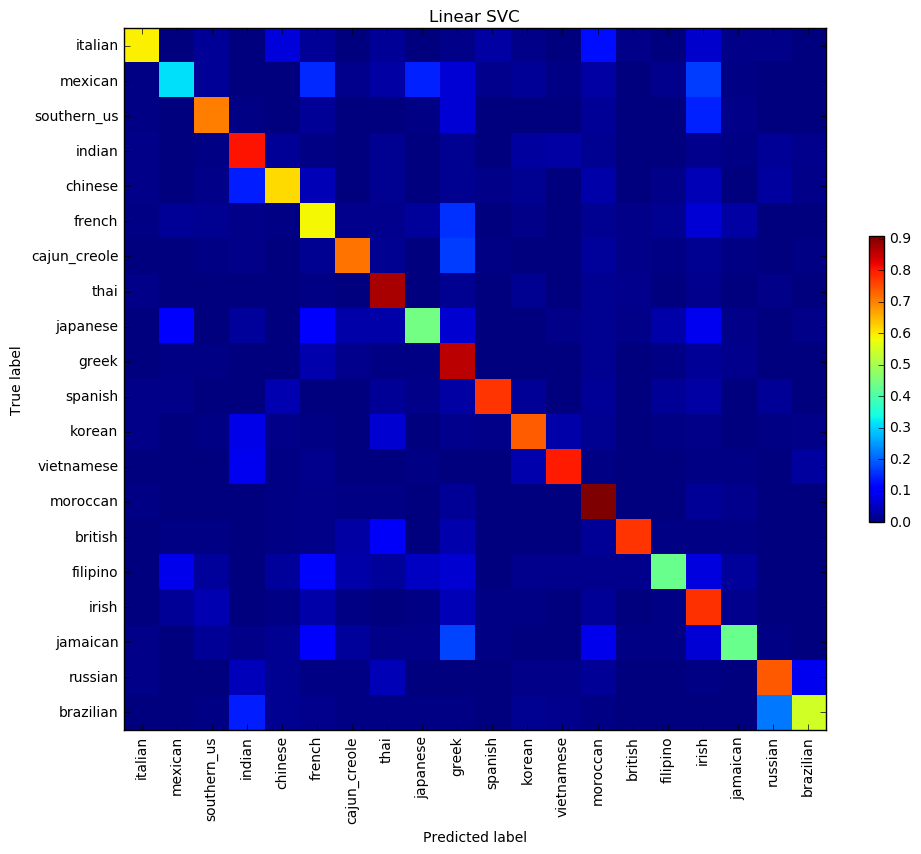

In [41]:
plt.figure(figsize=(10, 10))

cm = confusion_matrix(ltest, lsvc.predict(ctest))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, interpolation='nearest')
plt.title('Linear SVC')
plt.colorbar(shrink=0.3)
cuisines = train['cuisine'].value_counts().index
tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# ETC

In [42]:
etc = ensemble.ExtraTreesClassifier(n_estimators = 10, criterion = 'gini', class_weight='balanced')
etc.fit(ctrain, ltrain)
print etc.score(ctest, ltest)
print("%0.2f seconds" % (time() - t0))

0.672532998114
80.70 seconds


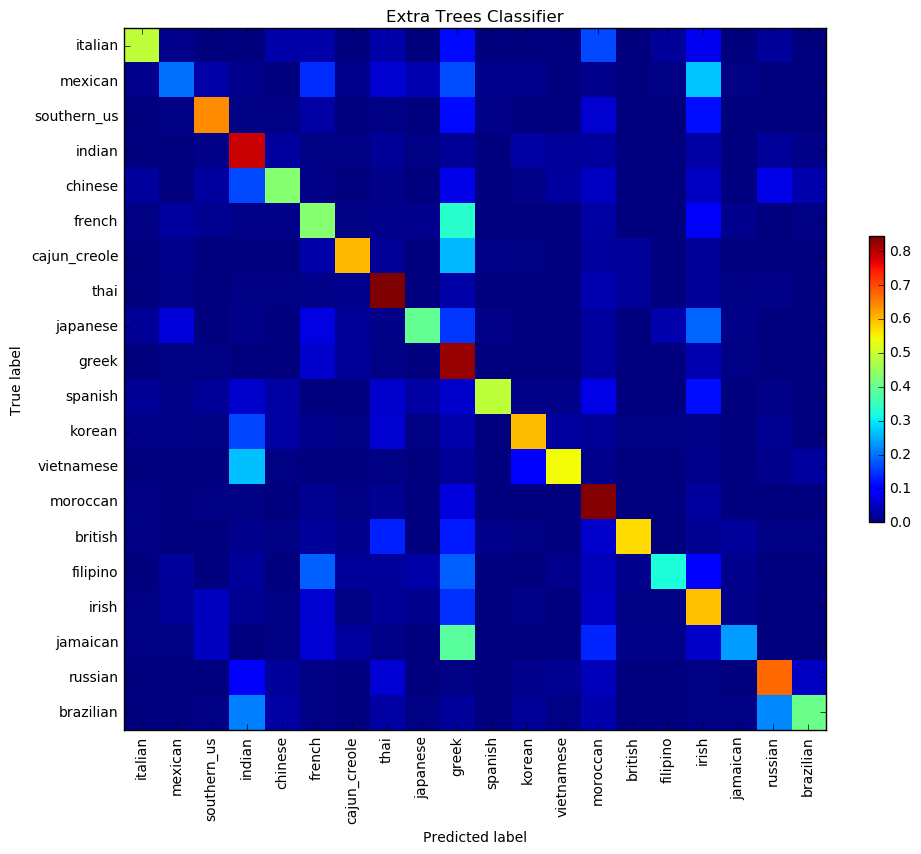

In [43]:
plt.figure(figsize=(10, 10))

cm = confusion_matrix(ltest, etc.predict(ctest))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, interpolation='nearest')
plt.title('Extra Trees Classifier')
plt.colorbar(shrink=0.3)
cuisines = train['cuisine'].value_counts().index
tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Perceptron

In [44]:
pcp = linear_model.Perceptron(alpha = 0.0001, n_iter = 15, class_weight = 'balanced', random_state = 4487)
pcp.fit(ctrain, ltrain)
print pcp.score(ctest, ltest)
print("%0.2f seconds" % (time() - t0))

0.687366436204
257.46 seconds


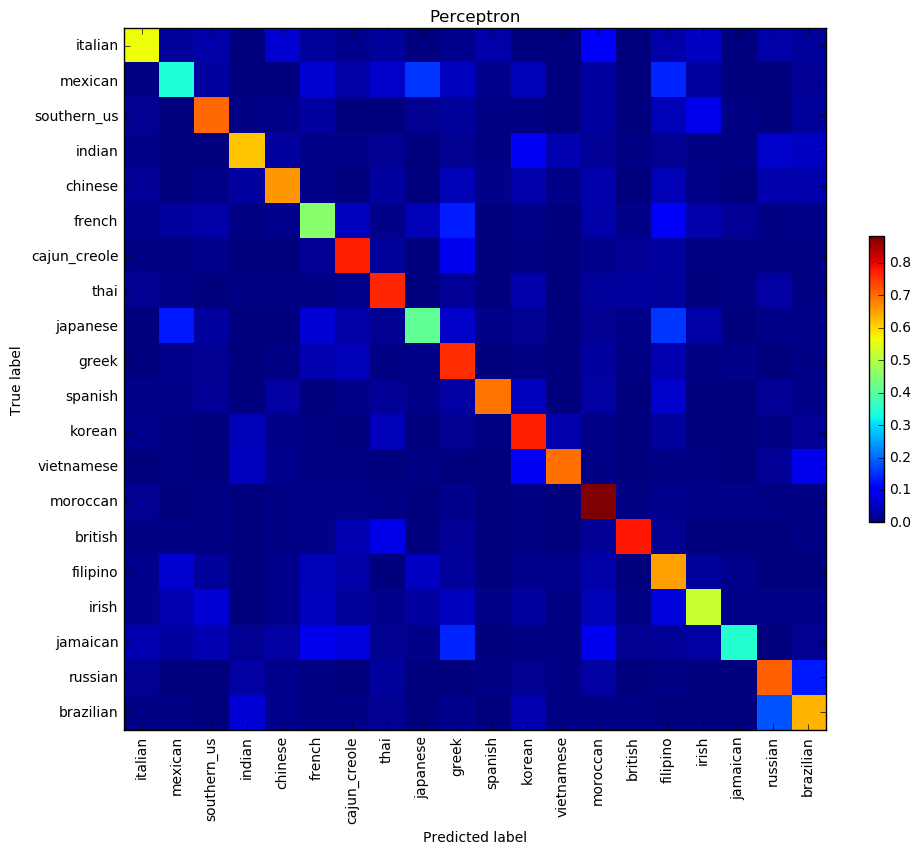

In [45]:
plt.figure(figsize=(10, 10))

cm = confusion_matrix(ltest, pcp.predict(ctest))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, interpolation='nearest')
plt.title('Perceptron')
plt.colorbar(shrink=0.3)
cuisines = train['cuisine'].value_counts().index
tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Ensemble

In [48]:
t0 = time()
vensemble = ensemble.VotingClassifier(estimators=[
        ('lr', linear_model.LogisticRegression(C=10)), 
        ('lrb', linear_model.LogisticRegression(C=3.7, class_weight='balanced')),
        ('svc', svm.SVC(kernel='linear', C=0.5, probability=True)), 
        ('svcb', svm.SVC(kernel='linear', C=0.5, probability=True, class_weight='balanced')), 
        ('mnb', naive_bayes.MultinomialNB(alpha=0.01)), 
        ('bnb', naive_bayes.BernoulliNB(alpha=1)),
        ('rfg', ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'gini', class_weight='balanced')), 
        ('rfe', ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'entropy', class_weight='balanced')),
        ('etg', ensemble.ExtraTreesClassifier(n_estimators=100, criterion='gini', class_weight='balanced')),
        ('ete', ensemble.ExtraTreesClassifier(n_estimators=100, criterion='entropy', class_weight='balanced')),
    ], voting='soft', weights=[2,2,2,2,1,1,1,1,1,1])
vensemble.fit(ctrain, ltrain)
print vsensemble.score(ctest, ltest)
print("%0.2f seconds" % (time() - t0))

#is shamelessly slow
#but shows good performance

0.802156548869
12297.33 seconds


In [ ]:
'''t0 = time()
vensemble = ensemble.VotingClassifier(estimators=[
        ('lr', linear_model.LogisticRegression(C=10)), 
        ('svc', svm.SVC(kernel='linear', C=0.5, probability=True)), 
        ('mnb', naive_bayes.MultinomialNB(alpha=0.01)), 
        ('bnb', naive_bayes.BernoulliNB(alpha=1)),
        ('rfg', ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'gini', class_weight='balanced')), 
        ('etg', ensemble.ExtraTreesClassifier(n_estimators=100, criterion='gini', class_weight='balanced')),
    ], voting='soft', weights=[2,2,1,1,1,1])
vensemble.fit(ctrain, ltrain)
print("%0.2f seconds" % (time() - t0))
print vsensemble.score(ctest, ltest)'''

In [ ]:
'''vensemble = ensemble.VotingClassifier(estimators=[
        ('lr', linear_model.LogisticRegression(C=10)), 
        ('svc', svm.SVC(kernel='linear', C=0.5, probability=True)), 
        ('bnb', naive_bayes.BernoulliNB(alpha=1)),
    ], voting='soft', weights=[2,2,1])'''

In [ ]:
'''t0 = time()
vensemble.fit(ctrain, ltrain)
print("%0.2f seconds" % (time() - t0))'''

In [ ]:
'''print vsensemble.score(ctest, ltest)'''